<a href="https://colab.research.google.com/github/ttvhh/CS114.K21/blob/master/Car_License_Plate_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!git clone https://github.com/thangnch/MiAI_LP_Detection_SVM

fatal: destination path 'MiAI_LP_Detection_SVM' already exists and is not an empty directory.


In [16]:
!pip install -r /content/MiAI_LP_Detection_SVM/setup.txt

In [17]:
import cv2
import os
import numpy as np
import glob

digit_w = 30
digit_h = 60

write_path="/content/MiAI_LP_Detection_SVM/data/"

def get_digit_data(path):#:, digit_list, label_list):

    digit_list = []
    label_list = []

    for number in range(10):
        i=0
        for img_org_path in glob.iglob(path + str(number) + '/*.jpg'):
            print(img_org_path)
            img = cv2.imread(img_org_path, 0)
            img = np.array(img)
            img = img.reshape(-1, digit_h * digit_w)

            print(img.shape)

            digit_list.append(img)
            label_list.append([int(number)])

    for number in range(65, 91):
        #number = chr(number)
        print(number)
        i=0
        for img_org_path in glob.iglob(path + str(number) + '/*.jpg'):
            print(img_org_path)
            img = cv2.imread(img_org_path, 0)
            img = np.array(img)
            img = img.reshape(-1, digit_h * digit_w)

            print(img.shape)

            digit_list.append(img)
            label_list.append([int(number)])

    return  digit_list, label_list

#lấy dữ liệu
digit_path = "/content/MiAI_LP_Detection_SVM/data/"
digit_list, label_list = get_digit_data(digit_path)

digit_list = np.array(digit_list, dtype=np.float32)
digit_list = digit_list.reshape(-1, digit_h * digit_w)

label_list = np.array(label_list)
label_list = label_list.reshape(-1, 1)

svm_model = cv2.ml.SVM_create()
svm_model.setType(cv2.ml.SVM_C_SVC)
svm_model.setKernel(cv2.ml.SVM_INTER)
svm_model.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-6))
svm_model.train(digit_list, cv2.ml.ROW_SAMPLE, label_list)

svm_model.save("svm.xml")


/content/MiAI_LP_Detection_SVM/data/0/46514_4.jpg
(1, 1800)
/content/MiAI_LP_Detection_SVM/data/0/46914_4.jpg
(1, 1800)
/content/MiAI_LP_Detection_SVM/data/0/46367_4.jpg
(1, 1800)
/content/MiAI_LP_Detection_SVM/data/0/1163.jpg
(1, 1800)
/content/MiAI_LP_Detection_SVM/data/0/46549_2.jpg
(1, 1800)
/content/MiAI_LP_Detection_SVM/data/0/46538_2.jpg
(1, 1800)
/content/MiAI_LP_Detection_SVM/data/0/46762_5.jpg
(1, 1800)
/content/MiAI_LP_Detection_SVM/data/0/46793_4.jpg
(1, 1800)
/content/MiAI_LP_Detection_SVM/data/0/46697_7.jpg
(1, 1800)
/content/MiAI_LP_Detection_SVM/data/0/46631_7.jpg
(1, 1800)
/content/MiAI_LP_Detection_SVM/data/0/46608_5.jpg
(1, 1800)
/content/MiAI_LP_Detection_SVM/data/0/46822_2.jpg
(1, 1800)
/content/MiAI_LP_Detection_SVM/data/0/46326_5.jpg
(1, 1800)
/content/MiAI_LP_Detection_SVM/data/0/46581_6.jpg
(1, 1800)
/content/MiAI_LP_Detection_SVM/data/0/47008_6.jpg
(1, 1800)
/content/MiAI_LP_Detection_SVM/data/0/46697_6.jpg
(1, 1800)
/content/MiAI_LP_Detection_SVM/data/0/46513

In [18]:
# pylint: disable=invalid-name, redefined-outer-name, missing-docstring, non-parent-init-called, trailing-whitespace, line-too-long
from os.path import splitext
import cv2
import numpy as np
from keras.models import model_from_json


class Label:
    def __init__(self, cl=-1, tl=np.array([0., 0.]), br=np.array([0., 0.]), prob=None):
        self.__tl = tl
        self.__br = br
        self.__cl = cl
        self.__prob = prob

    def __str__(self):
        return 'Class: %d, top left(x: %f, y: %f), bottom right(x: %f, y: %f)' % (
        self.__cl, self.__tl[0], self.__tl[1], self.__br[0], self.__br[1])

    def copy(self):
        return Label(self.__cl, self.__tl, self.__br)

    def wh(self): return self.__br - self.__tl

    def cc(self): return self.__tl + self.wh() / 2

    def tl(self): return self.__tl

    def br(self): return self.__br

    def tr(self): return np.array([self.__br[0], self.__tl[1]])

    def bl(self): return np.array([self.__tl[0], self.__br[1]])

    def cl(self): return self.__cl

    def area(self): return np.prod(self.wh())

    def prob(self): return self.__prob

    def set_class(self, cl):
        self.__cl = cl

    def set_tl(self, tl):
        self.__tl = tl

    def set_br(self, br):
        self.__br = br

    def set_wh(self, wh):
        cc = self.cc()
        self.__tl = cc - .5 * wh
        self.__br = cc + .5 * wh

    def set_prob(self, prob):
        self.__prob = prob

class DLabel(Label):
    def __init__(self, cl, pts, prob):
        self.pts = pts
        tl = np.amin(pts, axis=1)
        br = np.amax(pts, axis=1)
        Label.__init__(self, cl, tl, br, prob)

# Hàm normalize ảnh
def im2single(Image):
    return Image.astype('float32') / 255

def getWH(shape):
    return np.array(shape[1::-1]).astype(float)

def IOU(tl1, br1, tl2, br2):
    wh1, wh2 = br1-tl1, br2-tl2
    assert((wh1 >= 0).all() and (wh2 >= 0).all())
    
    intersection_wh = np.maximum(np.minimum(br1, br2) - np.maximum(tl1, tl2), 0)
    intersection_area = np.prod(intersection_wh)
    area1, area2 = (np.prod(wh1), np.prod(wh2))
    union_area = area1 + area2 - intersection_area
    return intersection_area/union_area

def IOU_labels(l1, l2):
    return IOU(l1.tl(), l1.br(), l2.tl(), l2.br())

def nms(Labels, iou_threshold=0.5):
    SelectedLabels = []
    Labels.sort(key=lambda l: l.prob(), reverse=True)
    
    for label in Labels:
        non_overlap = True
        for sel_label in SelectedLabels:
            if IOU_labels(label, sel_label) > iou_threshold:
                non_overlap = False
                break

        if non_overlap:
            SelectedLabels.append(label)
    return SelectedLabels

def load_model(path):
    path = splitext(path)[0]
    with open('%s.json' % path, 'r') as json_file:
        model_json = json_file.read()
    model = model_from_json(model_json, custom_objects={})
    model.load_weights('%s.h5' % path)
    return model

def find_T_matrix(pts, t_pts):
    A = np.zeros((8, 9))
    for i in range(0, 4):
        xi = pts[:, i]
        xil = t_pts[:, i]
        xi = xi.T
        
        A[i*2, 3:6] = -xil[2]*xi
        A[i*2, 6:] = xil[1]*xi
        A[i*2+1, :3] = xil[2]*xi
        A[i*2+1, 6:] = -xil[0]*xi

    [U, S, V] = np.linalg.svd(A)
    H = V[-1, :].reshape((3, 3))
    return H

def getRectPts(tlx, tly, brx, bry):
    return np.matrix([[tlx, brx, brx, tlx], [tly, tly, bry, bry], [1, 1, 1, 1]], dtype=float)

def normal(pts, side, mn, MN):
    pts_MN_center_mn = pts * side
    pts_MN = pts_MN_center_mn + mn.reshape((2, 1))
    pts_prop = pts_MN / MN.reshape((2, 1))
    return pts_prop

# Hàm tái tạo từ predict value thành biến số, cắt từ ảnh chính ra biển số,  nhãn...
def reconstruct(I, Iresized, Yr, lp_threshold):
    # 4 max-pooling layers, stride = 2
    net_stride = 2**4
    side = ((208 + 40)/2)/net_stride

    # one line and two lines license plate size
    one_line = (470, 110)
    two_lines = (280, 200)

    Probs = Yr[..., 0]
    Affines = Yr[..., 2:]

    xx, yy = np.where(Probs > lp_threshold)
    # CNN input image size 
    WH = getWH(Iresized.shape)
    # output feature map size
    MN = WH/net_stride

    vxx = vyy = 0.5 #alpha
    base = lambda vx, vy: np.matrix([[-vx, -vy, 1], [vx, -vy, 1], [vx, vy, 1], [-vx, vy, 1]]).T
    labels = []
    labels_frontal = []

    for i in range(len(xx)):
        x, y = xx[i], yy[i]
        affine = Affines[x, y]
        prob = Probs[x, y]

        mn = np.array([float(y) + 0.5, float(x) + 0.5])

        # affine transformation matrix
        A = np.reshape(affine, (2, 3))
        A[0, 0] = max(A[0, 0], 0)
        A[1, 1] = max(A[1, 1], 0)
        # identity transformation
        B = np.zeros((2, 3))
        B[0, 0] = max(A[0, 0], 0)
        B[1, 1] = max(A[1, 1], 0)

        pts = np.array(A*base(vxx, vyy))
        pts_frontal = np.array(B*base(vxx, vyy))

        pts_prop = normal(pts, side, mn, MN)
        frontal = normal(pts_frontal, side, mn, MN)

        labels.append(DLabel(0, pts_prop, prob))
        labels_frontal.append(DLabel(0, frontal, prob))

    final_labels = nms(labels, 0.1)
    final_labels_frontal = nms(labels_frontal, 0.1)

    print(final_labels_frontal)


    # LP size and type
    out_size, lp_type = (two_lines, 2) if ((final_labels_frontal[0].wh()[0] / final_labels_frontal[0].wh()[1]) < 1.7) else (one_line, 1)

    TLp = []
    if len(final_labels):
        final_labels.sort(key=lambda x: x.prob(), reverse=True)
        for _, label in enumerate(final_labels):
            t_ptsh = getRectPts(0, 0, out_size[0], out_size[1])
            ptsh = np.concatenate((label.pts * getWH(I.shape).reshape((2, 1)), np.ones((1, 4))))
            H = find_T_matrix(ptsh, t_ptsh)

            Ilp = cv2.warpPerspective(I, H, out_size, borderValue=0)
            TLp.append(Ilp)
    print(final_labels)
    return final_labels, TLp, lp_type

def detect_lp(model, I, max_dim, lp_threshold):

    # Tính factor resize ảnh
    min_dim_img = min(I.shape[:2])
    factor = float(max_dim) / min_dim_img

    # Tính W và H mới sau khi resize
    w, h = (np.array(I.shape[1::-1], dtype=float) * factor).astype(int).tolist()

    # Tiến hành resize ảnh
    Iresized = cv2.resize(I, (w, h))

    T = Iresized.copy()

    # Chuyển thành Tensor
    T = T.reshape((1, T.shape[0], T.shape[1], T.shape[2]))

    # Tiến hành detect biển số bằng Wpod-net pretrain
    Yr = model.predict(T)

    # Remove các chiều =1 của Yr
    Yr = np.squeeze(Yr)

    print(Yr.shape)

    # Tái tạo và trả về các biến gồm: Nhãn, Ảnh biến số, Loại biển số (1: dài: 2 vuông)
    L, TLp, lp_type = reconstruct(I, Iresized, Yr, lp_threshold)

    return L, TLp, lp_type

Using TensorFlow backend.


In [27]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
#from lib_detection.py import load_model, detect_lp, im2single


# Ham sap xep contour tu trai sang phai
def sort_contours(cnts):

    reverse = False
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

# Dinh nghia cac ky tu tren bien so
char_list =  '0123456789ABCDEFGHKLMNPRSTUVXYZ'

# Ham fine tune bien so, loai bo cac ki tu khong hop ly
def fine_tune(lp):
    newString = ""
    for i in range(len(lp)):
        if lp[i] in char_list:
            newString += lp[i]
    return newString

# Đường dẫn ảnh, các bạn đổi tên file tại đây để thử nhé
img_path = "/content/MiAI_LP_Detection_SVM/test/test2.jpg"

# Load model LP detection
wpod_net_path = "/content/MiAI_LP_Detection_SVM/wpod-net_update1.json"
wpod_net = load_model(wpod_net_path)

# Đọc file ảnh đầu vào
Ivehicle = cv2.imread(img_path)

# Kích thước lớn nhất và nhỏ nhất của 1 chiều ảnh
Dmax = 608
Dmin = 288

# Lấy tỷ lệ giữa W và H của ảnh và tìm ra chiều nhỏ nhất
ratio = float(max(Ivehicle.shape[:2])) / min(Ivehicle.shape[:2])
side = int(ratio * Dmin)
bound_dim = min(side, Dmax)

_ , LpImg, lp_type = detect_lp(wpod_net, im2single(Ivehicle), bound_dim, lp_threshold=0.5)


# Cau hinh tham so cho model SVM
digit_w = 30 # Kich thuoc ki tu
digit_h = 60 # Kich thuoc ki tu

model_svm = cv2.ml.SVM_load('/content/MiAI_LP_Detection_SVM/svm.xml')

if (len(LpImg)):

    # Chuyen doi anh bien so
    LpImg[0] = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))

    roi = LpImg[0]

    # Chuyen anh bien so ve gray
    gray = cv2.cvtColor( LpImg[0], cv2.COLOR_BGR2GRAY)


    # Ap dung threshold de phan tach so va nen
    binary = cv2.threshold(gray, 127, 255,
                         cv2.THRESH_BINARY_INV)[1]

    cv2.imshow("Anh bien so sau threshold", binary)
    #cv2.waitKey()

    # Segment kí tự
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
    cont, _  = cv2.findContours(thre_mor, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)


    plate_info = ""

    for c in sort_contours(cont):
        (x, y, w, h) = cv2.boundingRect(c)
        ratio = h/w
        if 1.5<=ratio<=3.5: # Chon cac contour dam bao ve ratio w/h
            if h/roi.shape[0]>=0.6: # Chon cac contour cao tu 60% bien so tro len

                # Ve khung chu nhat quanh so
                cv2.rectangle(roi, (x, y), (x + w, y + h), (0, 255, 0), 2)

                # Tach so va predict
                curr_num = thre_mor[y:y+h,x:x+w]
                curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
                _, curr_num = cv2.threshold(curr_num, 30, 255, cv2.THRESH_BINARY)
                curr_num = np.array(curr_num,dtype=np.float32)
                curr_num = curr_num.reshape(-1, digit_w * digit_h)

                # Dua vao model SVM
                result = model_svm.predict(curr_num)[1]
                result = int(result[0, 0])

                if result<=9: # Neu la so thi hien thi luon
                    result = str(result)
                else: #Neu la chu thi chuyen bang ASCII
                    result = chr(result)

                plate_info +=result

    cv2.imshow("Cac contour tim duoc", roi)
    #cv2.waitKey()

    # Viet bien so len anh
    cv2.putText(Ivehicle,fine_tune(plate_info),(50, 50), cv2.FONT_HERSHEY_PLAIN, 3.0, (0, 0, 255), lineType=cv2.LINE_AA)

    # Hien thi anh
    print("Bien so=", plate_info)
    cv2.imshow("Hinh anh output",Ivehicle)
    #cv2.waitKey()



#cv2.destroyAllWindows()

(32, 56, 8)


DisabledFunctionError: ignored

In [25]:
from google.colab.patches import cv2_imshow

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5500  100  5500    0     0  67901      0 --:--:-- --:--:-- --:--:-- 67901


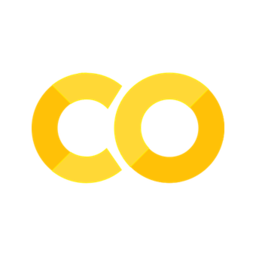

In [26]:
!curl -o logo.png https://colab.research.google.com/img/colab_favicon_256px.png
import cv2
img = cv2.imread('logo.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)